# **TAREA 2 - MACHINE LEARNING 2**
### **Assignment 2: Principal Component Analysis, Neural Networks**

**Integrantes:**

* Llaro Castro, Diego Renato
* Rios Meza, Jennifer Saskia
* Vargas Flores, Johanna Antonella

## **Part I: Eigenfaces for Face Recognition**

In [1]:
# IMPORTAMOS LIBRERÍAS
import os
import numpy as np
import imageio
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [2]:
# RUTA BASE DE IMÁGENES
base_path = '/workspaces/TAREA2_ML2_LLARO_RIOS_VARGAS/data/images'

# LEEMOS TRAIN Y TEST CSV/TXT

train_csv = pd.read_csv(
    '/workspaces/TAREA2_ML2_LLARO_RIOS_VARGAS/data/train.txt',
    sep=r'\s+',      # UNO O MÁS ESPACIOS COMO SEPARADOR
    header=None,     # EL ARCHIVO NO TIENE CABECERA
    usecols=[0,1],   # LEEMOS SOLO LAS DOS PRIMERAS COLUMNAS
    names=["image", "label"],
    engine='python'
).dropna()           # ELIMINAMOS FILAS VACÍAS

test_csv = pd.read_csv(
    '/workspaces/TAREA2_ML2_LLARO_RIOS_VARGAS/data/test.txt',
    sep=r'\s+',
    header=None,
    usecols=[0,1],
    names=["image", "label"],
    engine='python'
).dropna()

In [3]:
# CARGAMOS DATOS DE ENTRENAMIENTO
train_data, train_labels = [], []

for idx, row in train_csv.iterrows():
    img_name = str(row['image']).strip()       # QUITAR ESPACIOS
    label = int(row['label'])                  # CONVERTIR ETIQUETA A ENTERO
    img_path = os.path.join(base_path, os.path.basename(img_name))  # RUTA COMPLETA

    # VERIFICAMOS QUE EL ARCHIVO EXISTE
    if not os.path.exists(img_path):
        print(f"Archivo no encontrado: {img_path}")
        continue

    # LEEMOS LA IMAGEN Y LA APLANAMOS A 2500 DIMENSIONES
    im = imageio.v2.imread(img_path)
    train_data.append(im.reshape(2500,))
    train_labels.append(label)

train_data = np.array(train_data, dtype=float)
train_labels = np.array(train_labels, dtype=int)

print("IMÁGENES DE ENTRENAMIENTO CARGADAS:", len(train_data))


IMÁGENES DE ENTRENAMIENTO CARGADAS: 540


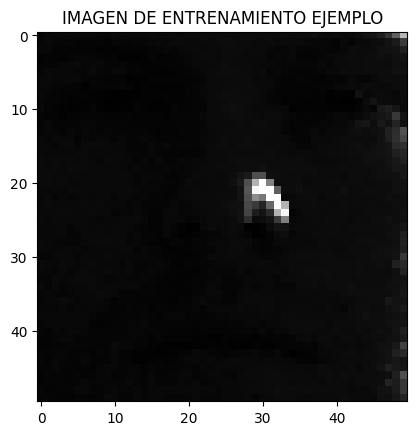

In [4]:
# MOSTRAMOS UNA IMAGEN DE EJEMPLO
if len(train_data) > 0:
    plt.imshow(train_data[0].reshape(50,50), cmap=cm.Greys_r)
    plt.title("IMAGEN DE ENTRENAMIENTO EJEMPLO")
    plt.show()
else:
    print("No se cargó ninguna imagen de entrenamiento.")

IMÁGENES DE PRUEBA CARGADAS: 100


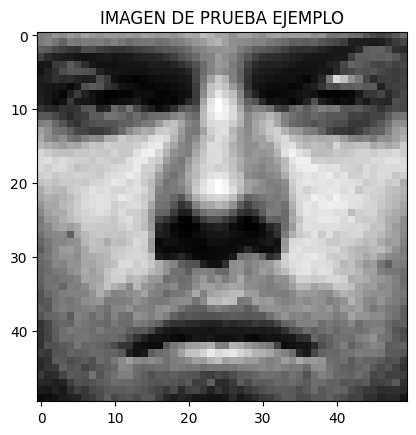

In [ ]:
# CARGAMOS LAS IMÁGENES DE PRUEBA
test_data, test_labels = [], []

for idx, row in test_csv.iterrows():
    img_name = str(row['image']).strip()
    label = int(row['label'])
    img_path = os.path.join(base_path, os.path.basename(img_name))

    if not os.path.exists(img_path):
        print(f"Archivo no encontrado: {img_path}")
        continue

    im = imageio.v2.imread(img_path)
    test_data.append(im.reshape(2500,))
    test_labels.append(label)

test_data = np.array(test_data, dtype=float)
test_labels = np.array(test_labels, dtype=int)

print("IMÁGENES DE PRUEBA CARGADAS:", len(test_data))

if len(test_data) > 0:
    plt.imshow(test_data[0].reshape(50,50), cmap=cm.Greys_r)
    plt.title("IMAGEN DE PRUEBA EJEMPLO")
    plt.show()
else:
    print("No se cargó ninguna imagen de prueba.")